# Определение возраста покупателей


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы

* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста.

Данные представлены в следующем виде:

В папке `/datasets/faces/` находится папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `'file_name'` и `'real_age'`.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Загрузка датасета

In [2]:
datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255.
)

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
datagen_flow = datagen.flow_from_dataframe(
    data,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    seed=42
)

Found 7591 validated image filenames.


In [5]:
features, target = next(datagen_flow)

In [6]:
features.shape

(32, 150, 150, 3)

In [7]:
target

array([ 1, 46, 35, 23, 47, 26, 20, 17, 25, 27, 47, 26, 37, 31, 94, 16, 35,
       37, 46, 21, 42, 22,  6, 26, 60, 73,  4, 55,  1,  8, 44, 27])

#### Исследовательский анализ

##### Распределение возраста

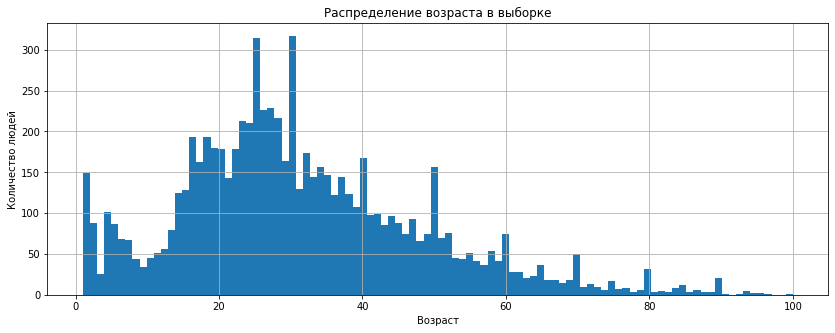

In [8]:
data['real_age'].hist(bins=100, figsize=(14, 5))
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

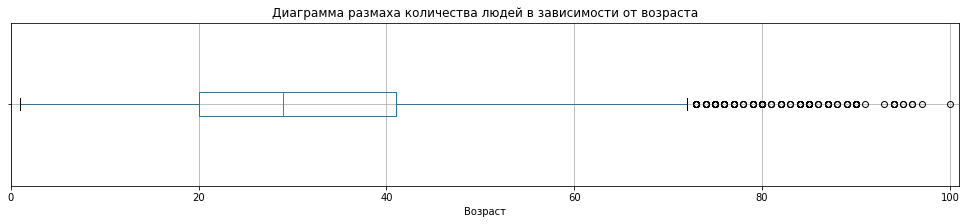

In [12]:
fig, ax = plt.subplots(figsize=(17, 3))
ax = data[['real_age']].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха количества людей в зависимости от возраста')
ax.set_xlabel('Возраст')
ax.set_xlim(0, 101)
plt.yticks([1], ['']);

In [13]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

* Большая часть людей находятся в возрасте примерно 18-40 лет (самые большие значения - примерно 25, 30 лет)

* Далее с возрастом начинается плавный спад количества людей, меньше всего людей в возрасте 80-100 лет

* В районе 0-20 лет (дети и подростки) наблюдается довольно интересное распределение количества людей по возрасту: пик около 0-1 года, потом спад примерно до 10 лет, а потом снова довольно сильный рост до 20 лет

* С точки зрения математики: распределение смещено вправо. Среднее: 31.2 года, медиана: 29 лет, стандартное отклонение: примерно 17 лет

* Что касается обучения модели. На мой взгляд, точнее всего будет предсказываться возрастная группа 16-40 лет, так как людей этого возраста больше всего, кроме того, распределение здесь более-менее равномерное, то есть на каждый возраст приходится примерно одинаковое количество народу, но есть некоторые пики. Наличие выбросов в возрасте может негативно сказаться на качестве модели

##### Примеры фотографий

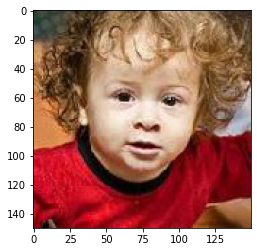

Age: 1
---------------------------


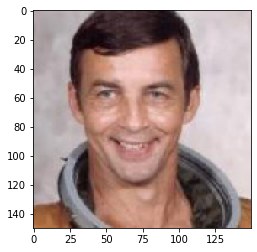

Age: 46
---------------------------


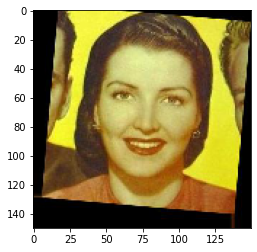

Age: 35
---------------------------


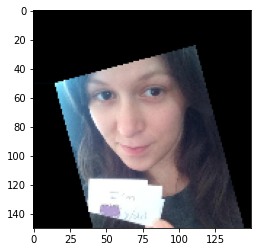

Age: 23
---------------------------


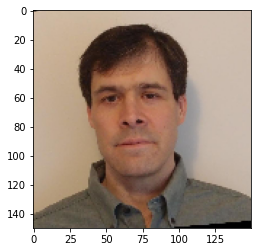

Age: 47
---------------------------


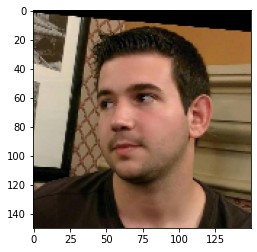

Age: 26
---------------------------


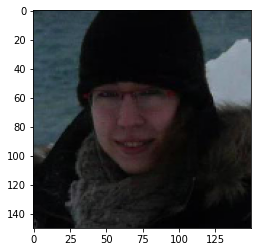

Age: 20
---------------------------


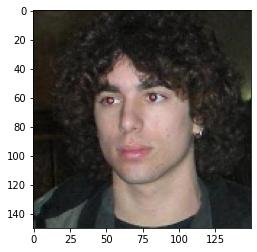

Age: 17
---------------------------


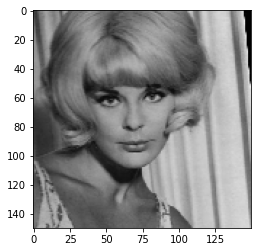

Age: 25
---------------------------


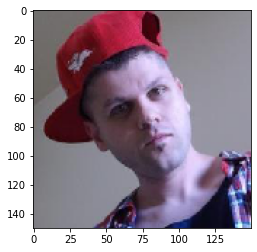

Age: 27
---------------------------


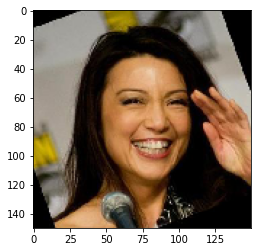

Age: 47
---------------------------


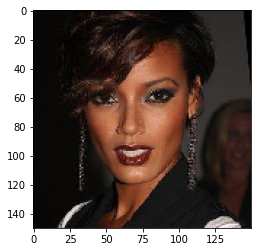

Age: 26
---------------------------


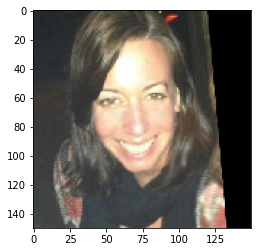

Age: 37
---------------------------


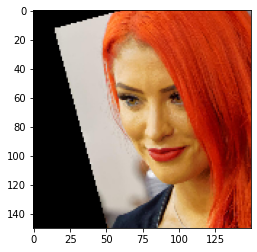

Age: 31
---------------------------


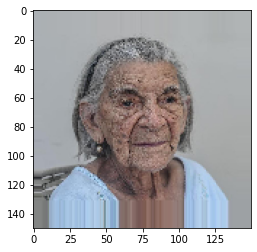

Age: 94
---------------------------


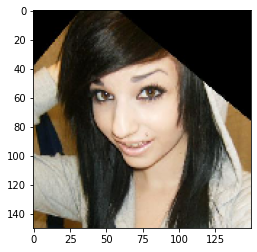

Age: 16
---------------------------


In [14]:
for i in range(16):
    plt.imshow(features[i])
    plt.show()
    print('Age: {}'.format(target[i]))
    print('---------------------------')

В целом фотографии неплохие, но, возможно, понадобятся аугментации, так как отдельные картинки находятся в неудачном ракурсе. Неправильно повернутые изображения могут "сбить нейросеть с толку", то есть привести к неверным предсказаниям.

## Обучение модели

Здесь прикреплен код, который использовался для обучения нейросети. Он запускался в отдельном тренажере с GPU, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    
    data = pd.read_csv(path + '/labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        data,
        path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )
    
    return train_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False
                       )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model


def load_test(path):
    val_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )
    
    data = pd.read_csv(path + '/labels.csv')
    
    val_datagen_flow = val_datagen.flow_from_dataframe(
        data,
        path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    
    return val_datagen_flow

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/7
2023-05-31 02:56:22.116298: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-31 02:56:22.411923: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 71s - loss: 269.2149 - mae: 11.8401 - val_loss: 905.1735 - val_mae: 25.1413
Epoch 2/7
178/178 - 60s - loss: 103.3561 - mae: 7.7153 - val_loss: 831.7297 - val_mae: 23.8023
Epoch 3/7
178/178 - 60s - loss: 84.7109 - mae: 7.0403 - val_loss: 344.2424 - val_mae: 13.7407
Epoch 4/7
178/178 - 60s - loss: 69.4258 - mae: 6.3530 - val_loss: 134.2152 - val_mae: 8.6606
Epoch 5/7
178/178 - 60s - loss: 62.4196 - mae: 6.0088 - val_loss: 94.0853 - val_mae: 7.3273
Epoch 6/7
178/178 - 60s - loss: 50.3865 - mae: 5.4546 - val_loss: 94.7815 - val_mae: 7.4625
Epoch 7/7
178/178 - 60s - loss: 45.0322 - mae: 5.1617 - val_loss: 75.5552 - val_mae: 6.5347
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 75.5552 - mae: 6.5347
Test MAE: 6.5347

```

## Анализ обученной модели

* Для решения задачи была использована модель ResNet50 из библиотеки keras. Оптимизатор - Adam, функция потерь - MSE, метрика - MAE. Модель была обучена на 7 эпохах, этого оказалось достаточно, чтобы достигнуть требуемой в задании точности

* Видно, что в начале обучения модель вела себя, как переобученная, однако уже на пятой эпохе расхождение между метриками на тренировочной и валидационной выборках стали малыми, что говорит о преодолении переобучения

* Величина MAE все еще довольно большая - почти семь лет, вероятно, это связано с наличием выбросов в данных, это видно из исследовательского анализа. Однако требуемая точность достигнута, поэтому задачу можно считать решенной